# Pure keras

### Has shuffling, normalisation, udf for model training, hyperas, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [2]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from hyperopt import Trials, STATUS_OK, tpe, STATUS_FAIL
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperas.utils import space_eval

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K

# Loding data directly from Tensorflow

In [5]:
def data():
    
    '''
    Data providing function:

    Make sure to have every relevant import statement included here and return data as
    used in model function below. This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    
    boston_housing = keras.datasets.boston_housing
    (x_train, y_train), (x_test, y_test) = boston_housing.load_data()    
    
    # Calculating column wise mean and std
    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)

    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std
    
    return x_train, y_train, x_test, y_test #these names must be same as the args of create model. Else x_train not defined error is thrown

In [6]:
def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential()
    model.add(Dense({{choice([32, 64, 128, 256,512])}}, input_shape=(13,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'two_hidden', add an additional layer
    if {{choice(['one_hidden', 'two_hidden'])}} == 'two_hidden':
        model.add(Dense({{choice([32, 64, 128, 256,512])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(loss='mse', metrics=['mae'],
                  optimizer={{choice(['rmsprop', 'adam', 'nadam','sgd'])}})
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience={{choice([10,20,30,40,50])}})
    
    model.fit(x_train, y_train,
              batch_size={{choice([16,32,64,128])}},
              epochs=500,
              callbacks=[early_stop],
              verbose=0,
              validation_split=0.2)
#               validation_data=(x_test, y_test))
    [loss, mae] = model.evaluate(x_test, y_test, verbose=0)
#     print('loss:',loss)
#     print('mae:',mae)
    
    # In cases where the loss turns out to be nan (due to bad network architecture)
    # An Assertion error is raised by hyperopt. Because of the nan value of loss.
    # So, to avoid such a case, we update loss to infinity in that case.
    if(np.isnan(mae)):
        print('nan loss')
        return {'loss': np.inf, 'status': STATUS_OK, 'model': model}
    
    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [7]:
if __name__ == '__main__':
    
    X_train, Y_train, X_test, Y_test = data()
    
    trials=Trials()
    best_run, best_model, space = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=100, #check how to pass maximum value
                                          trials=trials,
                                         notebook_name='4_house_price_prediction_pure_keras_param_opt_ver2',
                                          eval_space = True, #gives actual values of params in best run instead of list indeces
                                          verbose=False,
                                          return_space=True) #returns the search space of hyperopt. Can be used To display all the trails.
    
    print("\n\nEvalutation of best performing model:")
    print(best_model.evaluate(X_test, Y_test, verbose=0))
    print("\n\nBest performing model chosen hyper-parameters:")
    print(best_run)    

Testing set Mean Abs Error:    3.74
Testing set Mean Abs Error:    3.95
Testing set Mean Abs Error:    3.64
Testing set Mean Abs Error:   17.50
Testing set Mean Abs Error:    3.28
Testing set Mean Abs Error:     nan
Testing set Mean Abs Error:    4.15
Testing set Mean Abs Error:    4.00
Testing set Mean Abs Error:    3.65
Testing set Mean Abs Error:    3.60


AssertionError: 

In [7]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 512)               7168      
_________________________________________________________________
activation_115 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 512)               262656    
_________________________________________________________________
activation_116 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 513       
__________

In [8]:
# ----------------To get parameter value of each trial---------------------
for t, trial in enumerate(trials):
    vals = trial.get('misc').get('vals')
    print("Trial %s vals: %s" % (t, vals))
    tmp = {}
    for k,v in list(vals.items()):
        tmp[k] = v[0]
    print(space_eval(space, tmp))

Trial 0 vals: {'Activation': [0], 'Activation_1': [0], 'Dense': [1], 'Dense_1': [1], 'Dropout': [0.3207527760045966], 'Dropout_1': [1], 'Dropout_2': [0.7371698374615214], 'batch_size': [2], 'optimizer': [0], 'patience': [1]}
{'Activation': 'relu', 'Activation_1': 'relu', 'Dense': 64, 'Dense_1': 64, 'Dropout': 0.3207527760045966, 'Dropout_1': 'two_hidden', 'Dropout_2': 0.7371698374615214, 'batch_size': 64, 'optimizer': 'rmsprop', 'patience': 20}
Trial 1 vals: {'Activation': [0], 'Activation_1': [1], 'Dense': [1], 'Dense_1': [3], 'Dropout': [0.9770005173795487], 'Dropout_1': [1], 'Dropout_2': [0.42522861686845626], 'batch_size': [1], 'optimizer': [2], 'patience': [4]}
{'Activation': 'relu', 'Activation_1': 'sigmoid', 'Dense': 64, 'Dense_1': 256, 'Dropout': 0.9770005173795487, 'Dropout_1': 'two_hidden', 'Dropout_2': 0.42522861686845626, 'batch_size': 32, 'optimizer': 'nadam', 'patience': 50}
Trial 2 vals: {'Activation': [1], 'Activation_1': [1], 'Dense': [1], 'Dense_1': [4], 'Dropout': [0

Trial 49 vals: {'Activation': [1], 'Activation_1': [0], 'Dense': [4], 'Dense_1': [4], 'Dropout': [0.18902903599679766], 'Dropout_1': [0], 'Dropout_2': [0.5349263679384925], 'batch_size': [0], 'optimizer': [1], 'patience': [4]}
{'Activation': 'sigmoid', 'Activation_1': 'relu', 'Dense': 512, 'Dense_1': 512, 'Dropout': 0.18902903599679766, 'Dropout_1': 'one_hidden', 'Dropout_2': 0.5349263679384925, 'batch_size': 16, 'optimizer': 'adam', 'patience': 50}
Trial 50 vals: {'Activation': [0], 'Activation_1': [0], 'Dense': [4], 'Dense_1': [4], 'Dropout': [0.11729495644870092], 'Dropout_1': [1], 'Dropout_2': [0.09184988702290225], 'batch_size': [0], 'optimizer': [1], 'patience': [2]}
{'Activation': 'relu', 'Activation_1': 'relu', 'Dense': 512, 'Dense_1': 512, 'Dropout': 0.11729495644870092, 'Dropout_1': 'two_hidden', 'Dropout_2': 0.09184988702290225, 'batch_size': 16, 'optimizer': 'adam', 'patience': 30}
Trial 51 vals: {'Activation': [0], 'Activation_1': [1], 'Dense': [4], 'Dense_1': [4], 'Dropou

# Predicting on the Test data

In [9]:
test_predictions = best_model.predict(X_test).flatten()

In [10]:
predictions = pd.DataFrame(index=range(len(Y_test)))
predictions['actual'] = pd.DataFrame(Y_test)
predictions['preds'] = pd.DataFrame(test_predictions)

In [11]:
predictions

,actual,preds
0,7.2,8.882998
1,18.8,18.095352
2,19.0,20.751303
3,27.0,30.948114
4,22.2,23.557842
5,24.5,24.404249
6,31.2,28.266670
7,22.9,20.497667
8,20.5,19.672045
9,23.2,20.003736


# Plot

Text(0,0.5,'Predicted')

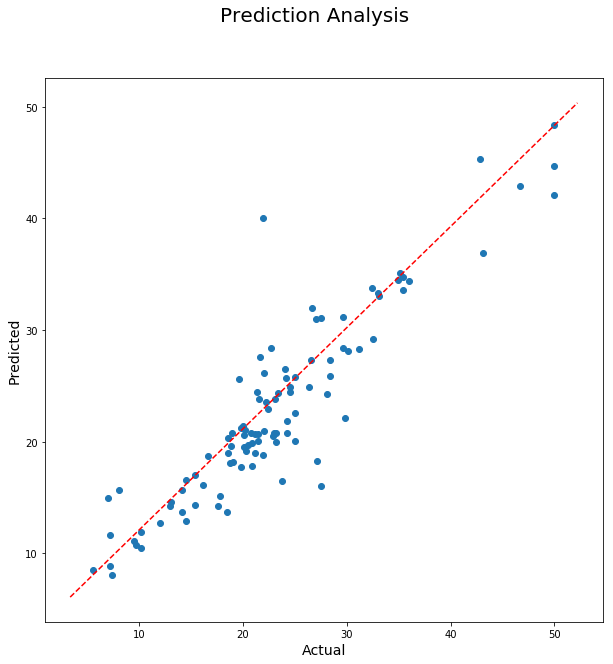

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)